# Data Preparation

In [1]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx
import os

from causallearn.search.FCMBased import lingam
from causallearn.search.FCMBased.lingam.utils import make_dot
from dowhy import CausalModel
import dowhy.gcm as gcm


np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}


def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine="dot")
    names = labels if labels else [f"x{i}" for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d


def str_to_dot(string):
    """
    Converts input string from graphviz library to valid DOT graph format.
    """
    graph = string.strip().replace("\n", ";").replace("\t", "")
    graph = (
        graph[:9] + graph[10:-2] + graph[-1]
    )  # Removing unnecessary characters from string
    return graph


folder_path = "/Users/lujun.li/projects/causallm-github/causalllm/resource/output/MT"

all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "sp_bleu" not in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

dataframe_final = pd.concat(all_dfs, ignore_index=True)

# data_df = data_df[["Temperature", "model", "elapsed_time", "spbleu", "dataset_name"]]
print(dataframe_final.shape)


def string_encode(data):
    unique_strings = data.unique()
    string_map = {string: i for i, string in enumerate(unique_strings)}
    encoded_data = data.map(string_map)
    return encoded_data


encoded_dataset_name = string_encode(dataframe_final["dataset_name"])
dataframe_final["dataset_encoded"] = encoded_dataset_name

dataframe_final.head()

(11874, 19)


,Unnamed: 0,Temperature,id,sentence_target,sentence_eng,dataset_name,initial_prompt,llama2_chat_initial_prompt,llama3_chat_initial_prompt,mixtral_instruct_initial_prompt,SYSTEM_MESSAGE,USER_MESSAGE,generated_response,timestamp,elapsed_time,temperature,model,model_name,weight_size,dataset_encoded
0,0,0.1,1,"""Issa għandna ġrieden ta' 4 xhur li mhumiex di...","""We now have 4-month-old mice that are non-dia...",mlt_Latn,\nInstruction: You are a translation expert ch...,<s>[INST] <<SYS>>\nYou are a translation exper...,<|begin_of_text|><|start_header_id|>system<|en...,<s>[INST]\nYou are a translation expert chatbo...,You are a translation expert chatbot. Don't an...,"""We now have 4-month-old mice that are non-dia...",<s>[INST] <<SYS>>\nYou are a translation exper...,2024-05-27 03:23:29,22.333449,0.1,Llama-2-13b-chat-hf,Llama-2-13b-chat-hf,13,0
1,1,0.1,2,"Dr. Ehud Ur, professur tal-mediċina fl-Univers...","Dr. Ehud Ur, professor of medicine at Dalhousi...",mlt_Latn,\nInstruction: You are a translation expert ch...,<s>[INST] <<SYS>>\nYou are a translation exper...,<|begin_of_text|><|start_header_id|>system<|en...,<s>[INST]\nYou are a translation expert chatbo...,You are a translation expert chatbot. Don't an...,"Dr. Ehud Ur, professor of medicine at Dalhousi...",<s>[INST] <<SYS>>\nYou are a translation exper...,2024-05-27 03:23:37,7.325582,0.1,Llama-2-13b-chat-hf,Llama-2-13b-chat-hf,13,0
2,2,0.1,3,"Bħal xi esperti oħra, huwa xettiku dwar jekk i...","Like some other experts, he is skeptical about...",mlt_Latn,\nInstruction: You are a translation expert ch...,<s>[INST] <<SYS>>\nYou are a translation exper...,<|begin_of_text|><|start_header_id|>system<|en...,<s>[INST]\nYou are a translation expert chatbo...,You are a translation expert chatbot. Don't an...,"Like some other experts, he is skeptical about...",<s>[INST] <<SYS>>\nYou are a translation exper...,2024-05-27 03:23:39,2.307633,0.1,Llama-2-13b-chat-hf,Llama-2-13b-chat-hf,13,0
3,3,0.1,4,"Nhar it-Tnejn, Sara Danius, segretarja permane...","On Monday, Sara Danius, permanent secretary of...",mlt_Latn,\nInstruction: You are a translation expert ch...,<s>[INST] <<SYS>>\nYou are a translation exper...,<|begin_of_text|><|start_header_id|>system<|en...,<s>[INST]\nYou are a translation expert chatbo...,You are a translation expert chatbot. Don't an...,"On Monday, Sara Danius, permanent secretary of...",<s>[INST] <<SYS>>\nYou are a translation exper...,2024-05-27 03:24:11,31.480252,0.1,Llama-2-13b-chat-hf,Llama-2-13b-chat-hf,13,0
4,4,0.1,5,"Danius qal, ""Bħalissa m’aħna qed nagħmlu xejn....","Danius said, ""Right now we are doing nothing. ...",mlt_Latn,\nInstruction: You are a translation expert ch...,<s>[INST] <<SYS>>\nYou are a translation exper...,<|begin_of_text|><|start_header_id|>system<|en...,<s>[INST]\nYou are a translation expert chatbo...,You are a translation expert chatbot. Don't an...,"Danius said, ""Right now we are doing nothing. ...",<s>[INST] <<SYS>>\nYou are a translation exper...,2024-05-27 03:24:16,5.466179,0.1,Llama-2-13b-chat-hf,Llama-2-13b-chat-hf,13,0


In [2]:
from sacrebleu.metrics import BLEU


def extract_final_response(row):
    prompt = row[match_prompt_column(row)]
    response = row["generated_response"]
    return response[len(prompt) :]


def match_prompt_column(row):
    if "Llama-2" in row["model"]:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in row["model"] or "Mistral" in row["model"]:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in row["model"]:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def calculate_sp_bleu(row):
    reference = row["sentence_target"]
    generated_answer = row["generated_response_pure"]
    score = bleu.sentence_score(
        hypothesis=generated_answer, references=[reference]
    ).score
    return score


dataframe_final["generated_response_pure"] = dataframe_final.apply(
    extract_final_response, axis=1
)
bleu = BLEU(tokenize="flores101", effective_order=True)
dataframe_final["spbleu"] = dataframe_final.apply(calculate_sp_bleu, axis=1)

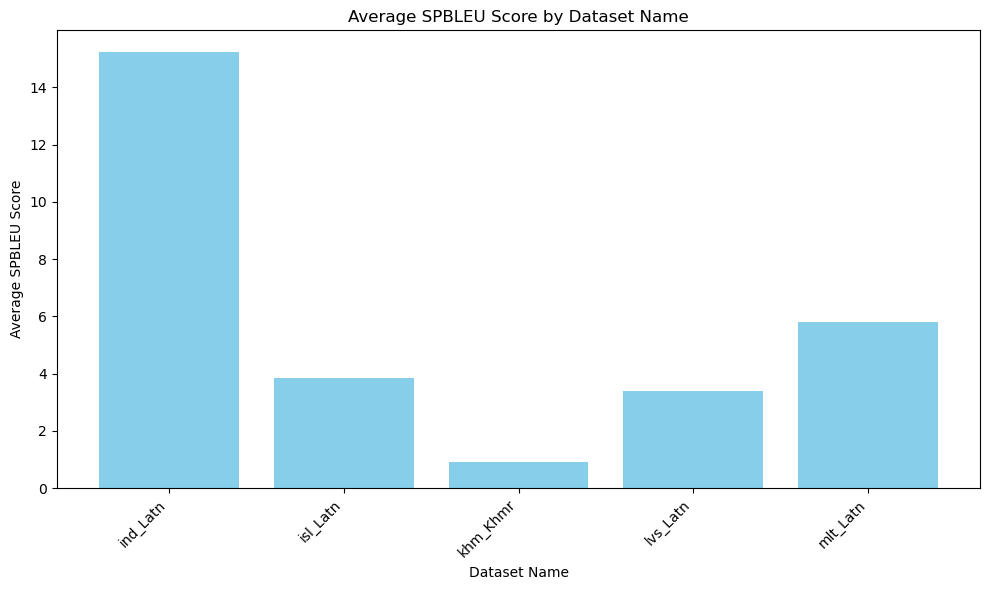

In [3]:
import matplotlib.pyplot as plt

grouped_results = dataframe_final.groupby("dataset_name")["spbleu"].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(grouped_results["dataset_name"], grouped_results["spbleu"], color="skyblue")
plt.xlabel("Dataset Name")
plt.ylabel("Average SPBLEU Score")
plt.title("Average SPBLEU Score by Dataset Name")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [4]:
dataframe_final = dataframe_final[
    [
        "Temperature",
        "elapsed_time",
        "spbleu",
        "dataset_encoded",
        "weight_size",
    ]
]
print(dataframe_final.shape)

(11874, 5)


In [5]:
dataframe_final.shape

# Data Based GCM Modeling Graph Causal Model

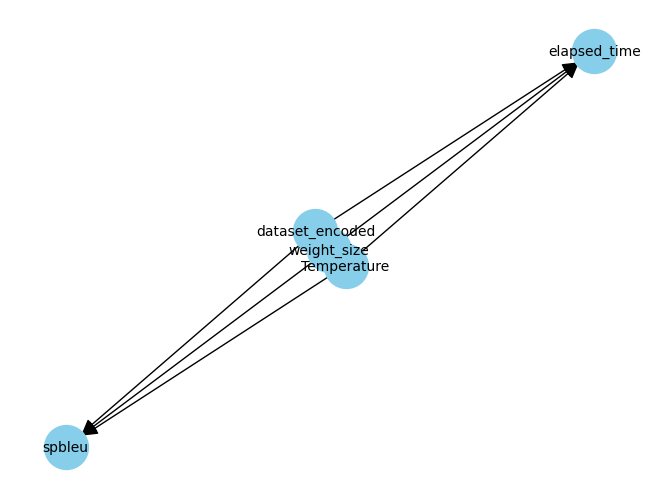

In [8]:
# Add prior knowledge
causal_graph = nx.DiGraph(
    [
        ("Temperature", "elapsed_time"),
        ("Temperature", "spbleu"),
        ("Temperature", "elapsed_time"),
        ("dataset_encoded", "elapsed_time"),
        ("dataset_encoded", "spbleu"),
        ("weight_size", "spbleu"),
        ("weight_size", "elapsed_time"),
    ]
)
pos = nx.spring_layout(causal_graph)
nx.draw(
    causal_graph,
    pos,
    with_labels=True,
    node_color="skyblue",
    node_size=1000,
    font_size=10,
    arrowsize=20,
)
plt.show()

See the data

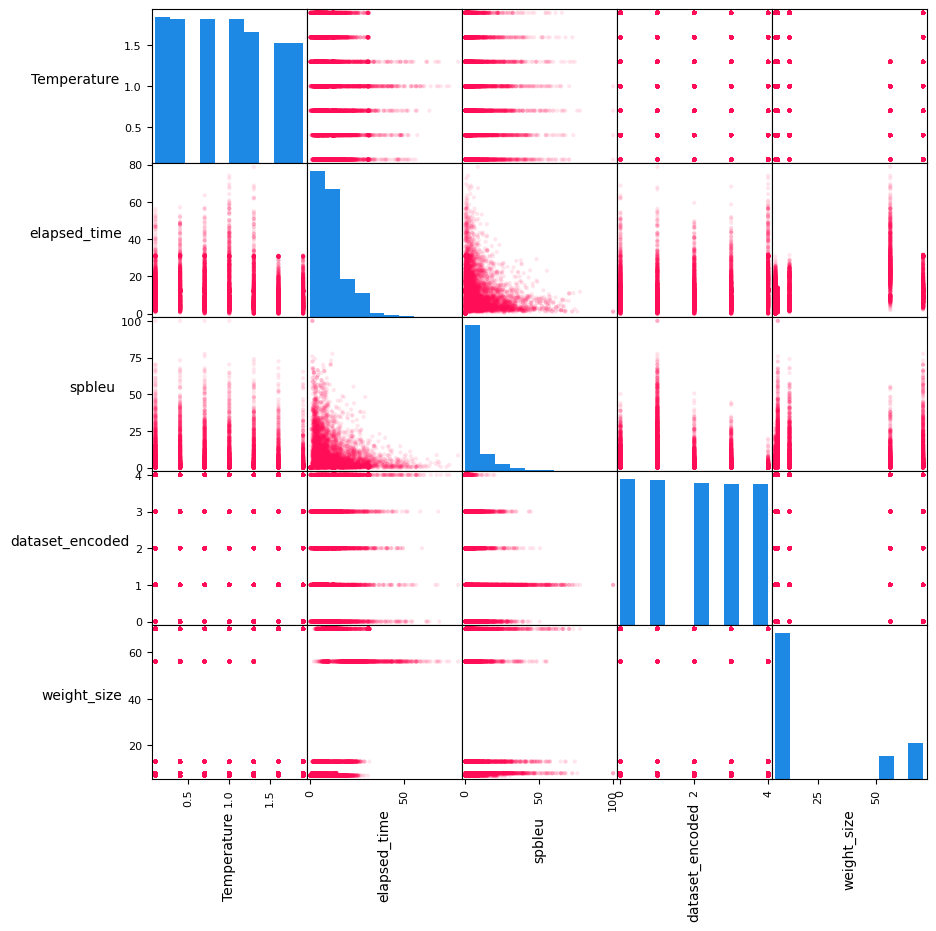

In [9]:
axes = pd.plotting.scatter_matrix(
    dataframe_final,
    figsize=(10, 10),
    c="#ff0d57",
    alpha=0.1,
    hist_kwds={"color": ["#1E88E5"]},
)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha("right")

In [12]:
causal_graph = nx.DiGraph(
    [
        ("Temperature", "elapsed_time"),
        ("Temperature", "spbleu"),
        ("Temperature", "elapsed_time"),
        ("dataset_encoded", "elapsed_time"),
        ("dataset_encoded", "spbleu"),
        ("weight_size", "spbleu"),
        ("weight_size", "elapsed_time"),
    ]
)

causal_model = gcm.StructuralCausalModel(
    causal_graph
)  # Automatic set the causal effect

quality = gcm.auto.AssignmentQuality.BEST
summary_auto_assignment = gcm.auto.assign_causal_mechanisms(
    causal_model, dataframe_final, quality=quality
)
print(summary_auto_assignment)

gcm.fit(causal_model, dataframe_final)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node spbleu:  40%|████      | 2/5 [00:42<01:03, 21.22s/it]      


KeyboardInterrupt: 

In [53]:
causal_model.causal_mechanism("Temperature")
for node in causal_model.graph.nodes:
    print(f"Node: {node}   {causal_model.causal_mechanism(node)}")

Node: Temperature   Empirical Distribution
Node: elapsed_time   AdditiveNoiseModel using AutoGluonRegressor
Node: spbleu   AdditiveNoiseModel using AutoGluonRegressor
Node: dataset_encoded   Empirical Distribution
Node: weight_size   Empirical Distribution


In [13]:
data_df_validation = pd.read_csv(
    "/Users/lujun.li/projects/causallm-github/causalllm/resource/output/MT/exp_result_Llama-2-70b-chat-hf_sp_bleu.csv"
)
data_df.dropna(inplace=True)
# data_df = data_df[["Temperature", "model", "elapsed_time", "spbleu", "dataset_name"]]
data_df_validation = data_df_validation[
    ["Temperature", "elapsed_time", "spbleu", "dataset_name", "model"]
]
print(data_df_validation.shape)
data_df_validation.head()

(2100, 5)


,Temperature,elapsed_time,spbleu,dataset_name,model
0,0.1,19.251106,2.692794,mlt_Latn,Llama-2-70b-chat-hf
1,0.1,13.183325,19.193097,mlt_Latn,Llama-2-70b-chat-hf
2,0.1,10.344519,3.268069,mlt_Latn,Llama-2-70b-chat-hf
3,0.1,15.676424,12.334265,mlt_Latn,Llama-2-70b-chat-hf
4,0.1,11.430753,2.051245,mlt_Latn,Llama-2-70b-chat-hf


Evaluating causal mechanisms...: 100%|██████████| 5/5 [00:00<00:00, 3689.57it/s]
/opt/anaconda3/envs/causalAnalysis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/causalAnalysis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/causalAnalysis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/causalAnalysis/lib/python3.9/site-packages/sklearn

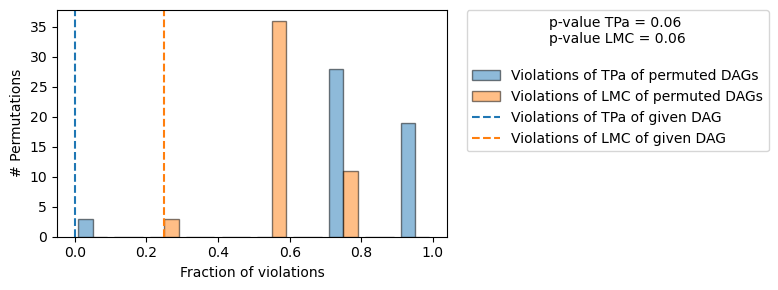

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [15]:
summary_evaluation = gcm.evaluate_causal_model(
    causal_model, data_df, compare_mechanism_baselines=True
)
print(summary_evaluation)

# Causal Model Using dowhy without gcm

Graphical Causal Models in Dowhy:

1. We have causal bayesian Network

2. We also have Functional Causal Model


Quantify causal effect, Counterfactural analysis

GCM you have a causal mechanism and this is a good API and then use this gcm api to all the causal query.

gcm. interventation, attribute_anaomalie 

But it's experimemtal !!!

Let's try without gcm !!!! 

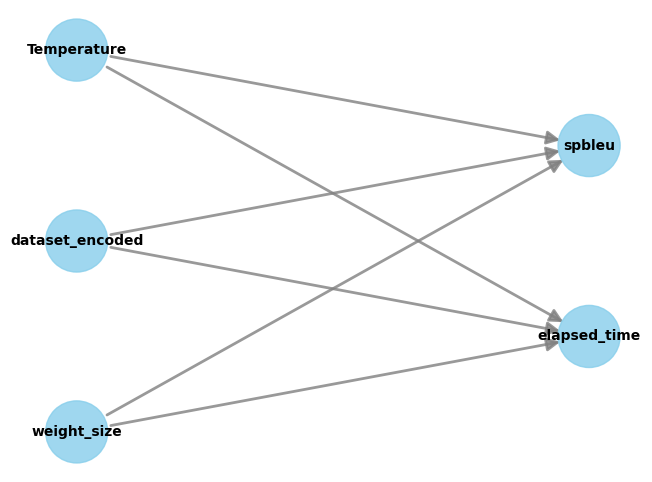

In [13]:
model = CausalModel(
    data=dataframe_final,
    treatment=["Temperature"],
    outcome=["spbleu", "elapsed_time"],
    effect_modifiers=["dataset_encoded", "weight_size"],
)
model.view_model()

In [14]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[spbleu])
d[Temperature]           
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→spbleu then P(spbleu|Temperature,,U) = P(spbleu|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
# Import the necessary libraries and functions for this demo
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.ensemble import GradientBoostingRegressor
from dowhy.gcm.falsify import (
    FalsifyConst,
    falsify_graph,
    plot_local_insights,
    run_validations,
    apply_suggestions,
)
from dowhy.gcm.independence_test.generalised_cov_measure import generalised_cov_based
from dowhy.gcm.util import plot
from dowhy.gcm.util.general import set_random_seed
from dowhy.gcm.ml import SklearnRegressionModel

# Set random seed
set_random_seed(1332)

# Run evaluation and plot the result using `plot=True`
result = falsify_graph(
    causal_graph=model._graph._graph,
    data=dataframe_final,
    plot_histogram=True,
    n_permutations=1000,
)
# Summarize the result
print(result)

In [17]:
dataframe_final.weight_size.value_counts()

weight_size
7     4200
13    2132
70    2100
8     2100
56    1342
Name: count, dtype: int64

Only effect estimation

In [81]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

start = 0
end = 2
num_points = 100
step = (end - start) / num_points
points = np.arange(start, end, step)
weight_sizes = dataframe_final["weight_size"].unique().tolist()
results_df = pd.DataFrame(
    columns=[
        "weight_size",
        "control_value",
        "treatement_value",
        "estimation_interpretation",
        "estimation_params",
        "estimation_effect",
    ]
)

for weight_size in weight_sizes:
    for point in points:
        dml_estimate = model.estimate_effect(
            identified_estimand,
            method_name="backdoor.econml.dml.DML",
            control_value=point,
            treatment_value=point + step,
            target_units=lambda df: df["weight_size"] == weight_size,
            confidence_intervals=False,
            # evaluate_effect_strength=True,
            method_params={
                "init_params": {
                    "model_y": GradientBoostingRegressor(),
                    "model_t": GradientBoostingRegressor(),
                    "model_final": LassoCV(fit_intercept=False),
                    "featurizer": PolynomialFeatures(degree=1, include_bias=False),
                },
                "fit_params": {},
            },
        )

        new_data = {
            "weight_size": weight_size,
            "control_value": point,
            "treatement_value": point + step,
            "estimation_interpretation": dml_estimate.interpret().__str__(),
            "estimation_params": [dml_estimate.params],
            "estimation_effect": [dml_estimate.value],
        }

        new_data_df = pd.DataFrame(new_data)
        results_df = pd.concat([results_df, new_data_df], ignore_index=True)
        print(len(results_df))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.0 to [0.02] causes an increase of -0.04211596120530846 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.02 to [0.04] causes an increase of -0.041829818544849455 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
2


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.04 to [0.06] causes an increase of -0.04200080441192732 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
3


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.06 to [0.08] causes an increase of -0.04220622067945034 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
4


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.08 to [0.1] causes an increase of -0.04193685576358974 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
5


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.1 to [0.12000000000000001] causes an increase of -0.041878432468039524 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
6


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.12 to [0.13999999999999999] causes an increase of -0.04198923836239899 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
7


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.14 to [0.16] causes an increase of -0.04193309866920597 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
8


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.16 to [0.18] causes an increase of -0.04220691195310726 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
9


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.18 to [0.19999999999999998] causes an increase of -0.04266518473786914 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.2 to [0.22] causes an increase of -0.042174989570791785 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
11


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.22 to [0.24] causes an increase of -0.041713571004562994 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
12


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.24 to [0.26] causes an increase of -0.04150540008494355 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
13


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.26 to [0.28] causes an increase of -0.041753889455692535 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
14


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.28 to [0.30000000000000004] causes an increase of -0.04226536216683552 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
15


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.3 to [0.32] causes an increase of -0.04197862959623473 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
16


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.32 to [0.34] causes an increase of -0.04204514614497179 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
17


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.34 to [0.36000000000000004] causes an increase of -0.041483897570706495 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
18


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.36 to [0.38] causes an increase of -0.042317661042420726 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
19


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.38 to [0.4] causes an increase of -0.04196606866550895 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
20


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.4 to [0.42000000000000004] causes an increase of -0.041832126984764094 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
21


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.42 to [0.44] causes an increase of -0.04250952425910208 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
22


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.44 to [0.46] causes an increase of -0.04171370739504734 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
23


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.46 to [0.48000000000000004] causes an increase of -0.04170773150993353 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
24


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.48 to [0.5] causes an increase of -0.0419786116385736 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
25


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.5 to [0.52] causes an increase of -0.04207017239442526 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
26


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.52 to [0.54] causes an increase of -0.042316234853121665 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
27


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.54 to [0.56] causes an increase of -0.041847692327565245 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
28


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.56 to [0.5800000000000001] causes an increase of -0.04193505008063209 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
29


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.58 to [0.6] causes an increase of -0.042411689748811716 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
30


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.6 to [0.62] causes an increase of -0.04159823001470186 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
31


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.62 to [0.64] causes an increase of -0.04202478038269594 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
32


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.64 to [0.66] causes an increase of -0.0421309997723876 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
33


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.66 to [0.68] causes an increase of -0.041571966467839123 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
34


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.68 to [0.7000000000000001] causes an increase of -0.04181496221890683 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
35


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.7000000000000001 to [0.7200000000000001] causes an increase of -0.04166894342066506 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
36


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.72 to [0.74] causes an increase of -0.04230696262831021 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
37


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.74 to [0.76] causes an increase of -0.04220618167860451 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
38


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.76 to [0.78] causes an increase of -0.042239379428419495 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
39


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.78 to [0.8] causes an increase of -0.042215938460142946 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
40


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.8 to [0.8200000000000001] causes an increase of -0.04206268273121376 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
41


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.8200000000000001 to [0.8400000000000001] causes an increase of -0.04191942783236854 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
42


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.84 to [0.86] causes an increase of -0.04181063782955341 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
43


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.86 to [0.88] causes an increase of -0.04215046499586048 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
44


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.88 to [0.9] causes an increase of -0.04207978274403998 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
45


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.9 to [0.92] causes an increase of -0.04178030666376399 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
46


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.92 to [0.9400000000000001] causes an increase of -0.042070658870912825 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
47


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.9400000000000001 to [0.9600000000000001] causes an increase of -0.042274333439520764 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
48


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.96 to [0.98] causes an increase of -0.04217888800931512 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
49


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.98 to [1.0] causes an increase of -0.0421202613722253 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
50


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.0 to [1.02] causes an increase of -0.04172096456871563 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
51


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.02 to [1.04] causes an increase of -0.042217225192809675 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
52


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.04 to [1.06] causes an increase of -0.04176450949022395 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
53


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.06 to [1.08] causes an increase of -0.04186922976071254 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
54


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.08 to [1.1] causes an increase of -0.04165889821339733 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
55


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.1 to [1.12] causes an increase of -0.043188081093423 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
56


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.12 to [1.1400000000000001] causes an increase of -0.0423455130295449 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
57


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.1400000000000001 to [1.1600000000000001] causes an increase of -0.04209099475609159 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
58


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.16 to [1.18] causes an increase of -0.042347315470375985 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
59


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.18 to [1.2] causes an increase of -0.042205832369639894 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
60


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.2 to [1.22] causes an increase of -0.04176234433487449 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
61


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.22 to [1.24] causes an increase of -0.04193165703577966 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
62


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.24 to [1.26] causes an increase of -0.041585152214700494 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
63


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.26 to [1.28] causes an increase of -0.04199985302515758 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
64


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.28 to [1.3] causes an increase of -0.04183013357846877 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
65


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.3 to [1.32] causes an increase of -0.04173044225908724 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
66


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.32 to [1.34] causes an increase of -0.042233892687557666 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
67


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.34 to [1.36] causes an increase of -0.041814264155938925 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
68


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.36 to [1.3800000000000001] causes an increase of -0.04182970831441338 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
69


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.3800000000000001 to [1.4000000000000001] causes an increase of -0.04184790284079209 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
70


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.4000000000000001 to [1.4200000000000002] causes an increase of -0.041929537040720354 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
71


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.42 to [1.44] causes an increase of -0.042132034992895404 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
72


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.44 to [1.46] causes an increase of -0.041817866457619805 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
73


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.46 to [1.48] causes an increase of -0.041886548048340765 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
74


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.48 to [1.5] causes an increase of -0.041487179389265064 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
75


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.5 to [1.52] causes an increase of -0.042200262097006475 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
76


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.52 to [1.54] causes an increase of -0.04221522064412168 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
77


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.54 to [1.56] causes an increase of -0.04181731158509097 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
78


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.56 to [1.58] causes an increase of -0.041782608639216685 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
79


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.58 to [1.6] causes an increase of -0.04211057644270425 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
80


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6 to [1.62] causes an increase of -0.04180879353550554 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
81


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.62 to [1.6400000000000001] causes an increase of -0.042292740962619285 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
82


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6400000000000001 to [1.6600000000000001] causes an increase of -0.04199203518228405 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
83


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6600000000000001 to [1.6800000000000002] causes an increase of -0.04204320927729547 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
84


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.68 to [1.7] causes an increase of -0.04192107961118244 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
85


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.7 to [1.72] causes an increase of -0.04191493770276673 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
86


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.72 to [1.74] causes an increase of -0.042380789508469026 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
87


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.74 to [1.76] causes an increase of -0.0422046963269323 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
88


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.76 to [1.78] causes an increase of -0.041679561915683234 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
89


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.78 to [1.8] causes an increase of -0.042054722236313166 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
90


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.8 to [1.82] causes an increase of -0.041858182889290683 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
91


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.82 to [1.84] causes an increase of -0.042261308050959186 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
92


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.84 to [1.86] causes an increase of -0.041945662848380846 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
93


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.86 to [1.8800000000000001] causes an increase of -0.04202260109815909 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
94


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.8800000000000001 to [1.9000000000000001] causes an increase of -0.042328258816294526 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
95


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.9000000000000001 to [1.9200000000000002] causes an increase of -0.04203628697490989 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
96


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.92 to [1.94] causes an increase of -0.041951956618085665 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
97


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.94 to [1.96] causes an increase of -0.04194487482692844 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
98


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.96 to [1.98] causes an increase of -0.04216852624532574 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
99


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.98 to [2.0] causes an increase of -0.041968335106471084 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
100


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.0 to [0.02] causes an increase of -0.04263256018561568 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
101


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.02 to [0.04] causes an increase of -0.04264012209790859 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
102


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.04 to [0.06] causes an increase of -0.04253068376001047 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
103


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.06 to [0.08] causes an increase of -0.04244952729211824 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
104


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.08 to [0.1] causes an increase of -0.04252340508427111 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
105


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.1 to [0.12000000000000001] causes an increase of -0.04260825401241392 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
106


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.12 to [0.13999999999999999] causes an increase of -0.042495609032587416 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
107


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.14 to [0.16] causes an increase of -0.04276748141691854 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
108


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.16 to [0.18] causes an increase of -0.04268285714124714 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
109


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.18 to [0.19999999999999998] causes an increase of -0.0428576568233925 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
110


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.2 to [0.22] causes an increase of -0.04239856335746479 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
111


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.22 to [0.24] causes an increase of -0.04307814558433203 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
112


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.24 to [0.26] causes an increase of -0.0423236040745379 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
113


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.26 to [0.28] causes an increase of -0.042421081725771075 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
114


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.28 to [0.30000000000000004] causes an increase of -0.04261214578915791 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
115


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.3 to [0.32] causes an increase of -0.0425504651850877 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
116


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.32 to [0.34] causes an increase of -0.04273319547160943 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
117


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.34 to [0.36000000000000004] causes an increase of -0.042591143891652514 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
118


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.36 to [0.38] causes an increase of -0.042407665437985076 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
119


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.38 to [0.4] causes an increase of -0.04247844316701328 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
120


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.4 to [0.42000000000000004] causes an increase of -0.04259404416218137 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
121


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.42 to [0.44] causes an increase of -0.04301515845785749 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
122


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.44 to [0.46] causes an increase of -0.0433075780086528 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
123


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.46 to [0.48000000000000004] causes an increase of -0.04237225136111908 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
124


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.48 to [0.5] causes an increase of -0.04269395291937326 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
125


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.5 to [0.52] causes an increase of -0.042560023734773814 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
126


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.52 to [0.54] causes an increase of -0.04234211536129748 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
127


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.54 to [0.56] causes an increase of -0.042526782362420315 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
128


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.56 to [0.5800000000000001] causes an increase of -0.042797699124038836 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
129


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.58 to [0.6] causes an increase of -0.043456940555325965 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
130


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.6 to [0.62] causes an increase of -0.042407113848311466 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
131


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.62 to [0.64] causes an increase of -0.04260300466279309 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
132


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.64 to [0.66] causes an increase of -0.04240345309040649 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
133


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.66 to [0.68] causes an increase of -0.04310246323099688 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
134


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.68 to [0.7000000000000001] causes an increase of -0.042833396899314743 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
135


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.7000000000000001 to [0.7200000000000001] causes an increase of -0.04264830656928359 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
136


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.72 to [0.74] causes an increase of -0.042588358491835024 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
137


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.74 to [0.76] causes an increase of -0.04334008184184483 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
138


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.76 to [0.78] causes an increase of -0.04249601455370916 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
139


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.78 to [0.8] causes an increase of -0.04403439077368493 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
140


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.8 to [0.8200000000000001] causes an increase of -0.04276927416962432 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
141


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.8200000000000001 to [0.8400000000000001] causes an increase of -0.042631514552360236 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
142


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.84 to [0.86] causes an increase of -0.04271552509965237 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
143


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.86 to [0.88] causes an increase of -0.04255841389588974 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
144


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.88 to [0.9] causes an increase of -0.04293141021480415 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
145


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.9 to [0.92] causes an increase of -0.04252922575377477 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
146


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.92 to [0.9400000000000001] causes an increase of -0.0424156382493324 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
147


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.9400000000000001 to [0.9600000000000001] causes an increase of -0.04288578548710769 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
148


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.96 to [0.98] causes an increase of -0.04253398580588727 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
149


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.98 to [1.0] causes an increase of -0.04272932700753962 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
150


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.0 to [1.02] causes an increase of -0.042710695044460685 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
151


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.02 to [1.04] causes an increase of -0.04267655446897817 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
152


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.04 to [1.06] causes an increase of -0.042833709194606766 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
153


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.06 to [1.08] causes an increase of -0.042606014767908824 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
154


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.08 to [1.1] causes an increase of -0.042814351520797135 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
155


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.1 to [1.12] causes an increase of -0.04257643178379976 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
156


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.12 to [1.1400000000000001] causes an increase of -0.04286196209410844 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
157


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.1400000000000001 to [1.1600000000000001] causes an increase of -0.04286764880172633 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
158


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.16 to [1.18] causes an increase of -0.04247931476690308 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
159


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.18 to [1.2] causes an increase of -0.042490886430705685 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
160


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.2 to [1.22] causes an increase of -0.04311361382998128 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
161


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.22 to [1.24] causes an increase of -0.042713528079357965 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
162


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.24 to [1.26] causes an increase of -0.042818891339208145 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
163


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.26 to [1.28] causes an increase of -0.04237240857391622 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
164


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.28 to [1.3] causes an increase of -0.04259356332502899 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
165


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.3 to [1.32] causes an increase of -0.04290689354831715 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
166


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.32 to [1.34] causes an increase of -0.04267201212357415 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
167


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.34 to [1.36] causes an increase of -0.04289384737210176 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
168


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.36 to [1.3800000000000001] causes an increase of -0.043098639757569605 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
169


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.3800000000000001 to [1.4000000000000001] causes an increase of -0.042574058019758144 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
170


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.4000000000000001 to [1.4200000000000002] causes an increase of -0.04245347995296667 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
171


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.42 to [1.44] causes an increase of -0.04214065009773085 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
172


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.44 to [1.46] causes an increase of -0.04323107057547629 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
173


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.46 to [1.48] causes an increase of -0.043037097083166394 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
174


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.48 to [1.5] causes an increase of -0.04268607767790896 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
175


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.5 to [1.52] causes an increase of -0.042608629049528425 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
176


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.52 to [1.54] causes an increase of -0.04204262820139482 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
177


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.54 to [1.56] causes an increase of -0.04229231654320687 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
178


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.56 to [1.58] causes an increase of -0.04256002856507104 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
179


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.58 to [1.6] causes an increase of -0.04178862300610504 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
180


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6 to [1.62] causes an increase of -0.042692075791246516 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
181


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.62 to [1.6400000000000001] causes an increase of -0.04248344307101113 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
182


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6400000000000001 to [1.6600000000000001] causes an increase of -0.042448888118525395 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
183


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6600000000000001 to [1.6800000000000002] causes an increase of -0.04263716942839213 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
184


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.68 to [1.7] causes an increase of -0.04266371674012853 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
185


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.7 to [1.72] causes an increase of -0.04290157771376177 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
186


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.72 to [1.74] causes an increase of -0.042463890221122055 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
187


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.74 to [1.76] causes an increase of -0.042687368443580655 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
188


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.76 to [1.78] causes an increase of -0.042801805705289894 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
189


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.78 to [1.8] causes an increase of -0.04270972740817179 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
190


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.8 to [1.82] causes an increase of -0.04299594138938998 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
191


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.82 to [1.84] causes an increase of -0.042819485244749 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
192


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.84 to [1.86] causes an increase of -0.04274028638193901 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
193


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.86 to [1.8800000000000001] causes an increase of -0.042532273521160784 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
194


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.8800000000000001 to [1.9000000000000001] causes an increase of -0.04228460934282026 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
195


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.9000000000000001 to [1.9200000000000002] causes an increase of -0.042854274091468796 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
196


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.92 to [1.94] causes an increase of -0.04274560463766783 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
197


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.94 to [1.96] causes an increase of -0.04332741481752261 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
198


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.96 to [1.98] causes an increase of -0.04218814085383857 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
199


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.98 to [2.0] causes an increase of -0.042677269324811674 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
200


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.0 to [0.02] causes an increase of -0.03198848972086297 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
201


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.02 to [0.04] causes an increase of -0.030870289467449706 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
202


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.04 to [0.06] causes an increase of -0.031138859062292072 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
203


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.06 to [0.08] causes an increase of -0.03166982542179081 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
204


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.08 to [0.1] causes an increase of -0.03132241784103255 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
205


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.1 to [0.12000000000000001] causes an increase of -0.03128090916053068 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
206


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.12 to [0.13999999999999999] causes an increase of -0.032846516058967545 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
207


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.14 to [0.16] causes an increase of -0.03093926130101857 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
208


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.16 to [0.18] causes an increase of -0.031289122648269344 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
209


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.18 to [0.19999999999999998] causes an increase of -0.031402498683649416 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
210


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.2 to [0.22] causes an increase of -0.030955821498041033 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
211


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.22 to [0.24] causes an increase of -0.029292635949256362 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
212


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.24 to [0.26] causes an increase of -0.03161623207146578 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
213


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.26 to [0.28] causes an increase of -0.033178435324252645 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
214


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.28 to [0.30000000000000004] causes an increase of -0.030802345771535844 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
215


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.3 to [0.32] causes an increase of -0.03174948565825141 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
216


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.32 to [0.34] causes an increase of -0.03268269868208685 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
217


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.34 to [0.36000000000000004] causes an increase of -0.031663703553511134 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
218


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.36 to [0.38] causes an increase of -0.031397781157679515 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
219


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.38 to [0.4] causes an increase of -0.03062199269799957 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
220


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.4 to [0.42000000000000004] causes an increase of -0.03144644364300108 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
221


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.42 to [0.44] causes an increase of -0.03114149778075071 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
222


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.44 to [0.46] causes an increase of -0.03070443600931415 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
223


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.46 to [0.48000000000000004] causes an increase of -0.032957054327044634 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
224


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.48 to [0.5] causes an increase of -0.03161102879620049 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
225


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.5 to [0.52] causes an increase of -0.03095055437327571 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
226


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.52 to [0.54] causes an increase of -0.030968577851993122 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
227


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.54 to [0.56] causes an increase of -0.03208976524467326 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
228


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.56 to [0.5800000000000001] causes an increase of -0.031298307651525845 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
229


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.58 to [0.6] causes an increase of -0.030893592113148103 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
230


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.6 to [0.62] causes an increase of -0.03110293493275982 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
231


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.62 to [0.64] causes an increase of -0.032189185631004626 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
232


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.64 to [0.66] causes an increase of -0.0324304038775244 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
233


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.66 to [0.68] causes an increase of -0.030660444492485037 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
234


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.68 to [0.7000000000000001] causes an increase of -0.03143422549675046 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
235


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.7000000000000001 to [0.7200000000000001] causes an increase of -0.03189915417954564 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
236


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.72 to [0.74] causes an increase of -0.031040867562519763 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
237


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.74 to [0.76] causes an increase of -0.03160254520488651 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
238


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.76 to [0.78] causes an increase of -0.0323531393662597 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
239


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.78 to [0.8] causes an increase of -0.0314611629174303 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
240


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.8 to [0.8200000000000001] causes an increase of -0.03150189904874918 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
241


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.8200000000000001 to [0.8400000000000001] causes an increase of -0.03226805441896727 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
242


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.84 to [0.86] causes an increase of -0.031172217007645598 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
243


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.86 to [0.88] causes an increase of -0.03129156277361478 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
244


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.88 to [0.9] causes an increase of -0.031739958800656984 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
245


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.9 to [0.92] causes an increase of -0.03214167629482295 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
246


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.92 to [0.9400000000000001] causes an increase of -0.03179924786155076 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
247


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.9400000000000001 to [0.9600000000000001] causes an increase of -0.031122412600346948 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
248


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.96 to [0.98] causes an increase of -0.03130650497135384 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
249


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.98 to [1.0] causes an increase of -0.030997887455416467 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
250


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.0 to [1.02] causes an increase of -0.03106907837170576 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
251


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.02 to [1.04] causes an increase of -0.03125372329492082 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
252


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.04 to [1.06] causes an increase of -0.03196610580172967 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
253


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.06 to [1.08] causes an increase of -0.031910426043768446 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
254


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.08 to [1.1] causes an increase of -0.03409475562622301 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
255


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.1 to [1.12] causes an increase of -0.03153248951077363 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
256


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.12 to [1.1400000000000001] causes an increase of -0.03269739655792154 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
257


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.1400000000000001 to [1.1600000000000001] causes an increase of -0.031357878049837425 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
258


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.16 to [1.18] causes an increase of -0.03208995772474256 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
259


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.18 to [1.2] causes an increase of -0.0317850923779896 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
260


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.2 to [1.22] causes an increase of -0.03252966300014023 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
261


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.22 to [1.24] causes an increase of -0.030823912578348128 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
262


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.24 to [1.26] causes an increase of -0.03181936809973135 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
263


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.26 to [1.28] causes an increase of -0.03134563081238056 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
264


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.28 to [1.3] causes an increase of -0.031893316240539614 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
265


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.3 to [1.32] causes an increase of -0.03256495898681871 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
266


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.32 to [1.34] causes an increase of -0.032248421374736345 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
267


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.34 to [1.36] causes an increase of -0.030327647217975987 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
268


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.36 to [1.3800000000000001] causes an increase of -0.03256273385202955 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
269


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.3800000000000001 to [1.4000000000000001] causes an increase of -0.031246865906251316 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
270


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.4000000000000001 to [1.4200000000000002] causes an increase of -0.031293672004261794 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
271


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.42 to [1.44] causes an increase of -0.030747959756625552 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
272


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.44 to [1.46] causes an increase of -0.031708252776913505 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
273


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.46 to [1.48] causes an increase of -0.03164405493798744 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
274


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.48 to [1.5] causes an increase of -0.030232588397516115 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
275


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.5 to [1.52] causes an increase of -0.03180196752384014 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
276


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.52 to [1.54] causes an increase of -0.03191411399761162 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
277


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.54 to [1.56] causes an increase of -0.031349298531647155 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
278


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.56 to [1.58] causes an increase of -0.03137602384660042 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
279


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.58 to [1.6] causes an increase of -0.03265219183059727 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
280


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6 to [1.62] causes an increase of -0.031341026689872035 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
281


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.62 to [1.6400000000000001] causes an increase of -0.03236448890494116 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
282


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6400000000000001 to [1.6600000000000001] causes an increase of -0.031339917461697564 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
283


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6600000000000001 to [1.6800000000000002] causes an increase of -0.03200427471164215 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
284


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.68 to [1.7] causes an increase of -0.032171122717680564 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
285


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.7 to [1.72] causes an increase of -0.03163631046968574 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
286


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.72 to [1.74] causes an increase of -0.030205298066238888 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
287


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.74 to [1.76] causes an increase of -0.03114770561439756 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
288


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.76 to [1.78] causes an increase of -0.03188363512681979 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
289


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.78 to [1.8] causes an increase of -0.030862337234261638 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
290


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.8 to [1.82] causes an increase of -0.030474268220675615 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
291


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.82 to [1.84] causes an increase of -0.03132731602550751 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
292


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.84 to [1.86] causes an increase of -0.031642809141295115 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
293


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.86 to [1.8800000000000001] causes an increase of -0.031679320179923996 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
294


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.8800000000000001 to [1.9000000000000001] causes an increase of -0.032644110121707245 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
295


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.9000000000000001 to [1.9200000000000002] causes an increase of -0.03211833711506879 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
296


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.92 to [1.94] causes an increase of -0.031149141130226456 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
297


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.94 to [1.96] causes an increase of -0.03142511867210902 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
298


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.96 to [1.98] causes an increase of -0.030392292489923527 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
299


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.98 to [2.0] causes an increase of -0.030942730788379016 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
300


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.0 to [0.02] causes an increase of -0.04231071869101857 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
301


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.02 to [0.04] causes an increase of -0.04202161218637437 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
302


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.04 to [0.06] causes an increase of -0.042443676755133976 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
303


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.06 to [0.08] causes an increase of -0.04218196335564282 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
304


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.08 to [0.1] causes an increase of -0.042399233516398745 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
305


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.1 to [0.12000000000000001] causes an increase of -0.042330552957965034 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
306


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.12 to [0.13999999999999999] causes an increase of -0.042591923232462366 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
307


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.14 to [0.16] causes an increase of -0.0422051118176882 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
308


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.16 to [0.18] causes an increase of -0.042421997554257664 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
309


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.18 to [0.19999999999999998] causes an increase of -0.04242365969423423 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
310


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.2 to [0.22] causes an increase of -0.042708419054878634 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
311


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.22 to [0.24] causes an increase of -0.04245181377115904 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
312


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.24 to [0.26] causes an increase of -0.04251339645348983 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
313


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.26 to [0.28] causes an increase of -0.04262542881882318 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
314


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.28 to [0.30000000000000004] causes an increase of -0.04253271450361035 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
315


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.3 to [0.32] causes an increase of -0.04272190465312708 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
316


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.32 to [0.34] causes an increase of -0.04236600723065274 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
317


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.34 to [0.36000000000000004] causes an increase of -0.04206643524898413 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
318


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.36 to [0.38] causes an increase of -0.04245169420195281 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
319


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.38 to [0.4] causes an increase of -0.04239233679864693 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
320


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.4 to [0.42000000000000004] causes an increase of -0.0422658799593491 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
321


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.42 to [0.44] causes an increase of -0.04215656586786473 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
322


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.44 to [0.46] causes an increase of -0.042883782871481285 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
323


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.46 to [0.48000000000000004] causes an increase of -0.04281437629197671 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
324


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.48 to [0.5] causes an increase of -0.04244341367154793 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
325


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.5 to [0.52] causes an increase of -0.042603039161010416 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
326


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.52 to [0.54] causes an increase of -0.04255644541667515 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
327


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.54 to [0.56] causes an increase of -0.042210665118368 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
328


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.56 to [0.5800000000000001] causes an increase of -0.04211253733078958 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
329


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.58 to [0.6] causes an increase of -0.04218532591458391 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
330


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.6 to [0.62] causes an increase of -0.04247365078862284 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
331


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.62 to [0.64] causes an increase of -0.042162504747574006 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
332


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.64 to [0.66] causes an increase of -0.042715855388340294 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
333


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.66 to [0.68] causes an increase of -0.042533502592971326 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
334


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.68 to [0.7000000000000001] causes an increase of -0.04263217947921377 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
335


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.7000000000000001 to [0.7200000000000001] causes an increase of -0.04315284427420245 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
336


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.72 to [0.74] causes an increase of -0.04271914274636607 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
337


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.74 to [0.76] causes an increase of -0.04232361380416162 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
338


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.76 to [0.78] causes an increase of -0.042425205319777885 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
339


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.78 to [0.8] causes an increase of -0.04282852787749744 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
340


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.8 to [0.8200000000000001] causes an increase of -0.042307153276988446 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
341


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.8200000000000001 to [0.8400000000000001] causes an increase of -0.04210173045125596 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
342


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.84 to [0.86] causes an increase of -0.04256638519922327 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
343


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.86 to [0.88] causes an increase of -0.04270449676420193 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
344


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.88 to [0.9] causes an increase of -0.04292153041170498 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
345


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.9 to [0.92] causes an increase of -0.04237749657974015 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
346


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.92 to [0.9400000000000001] causes an increase of -0.04222520535877466 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
347


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.9400000000000001 to [0.9600000000000001] causes an increase of -0.04272435724755094 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
348


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.96 to [0.98] causes an increase of -0.042270125577669626 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
349


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.98 to [1.0] causes an increase of -0.04233287121994487 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
350


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.0 to [1.02] causes an increase of -0.04220436865693791 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
351


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.02 to [1.04] causes an increase of -0.0430783350602095 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
352


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.04 to [1.06] causes an increase of -0.04252273151445612 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
353


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.06 to [1.08] causes an increase of -0.042639336722793075 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
354


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.08 to [1.1] causes an increase of -0.042682364113076146 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
355


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.1 to [1.12] causes an increase of -0.0427533533807975 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
356


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.12 to [1.1400000000000001] causes an increase of -0.04220100698466025 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
357


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.1400000000000001 to [1.1600000000000001] causes an increase of -0.042453145459539404 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
358


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.16 to [1.18] causes an increase of -0.04235261979189779 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
359


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.18 to [1.2] causes an increase of -0.042696591168946606 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
360


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.2 to [1.22] causes an increase of -0.04248038983608557 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
361


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.22 to [1.24] causes an increase of -0.04214089320422895 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
362


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.24 to [1.26] causes an increase of -0.04245232322107617 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
363


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.26 to [1.28] causes an increase of -0.04219809235420533 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
364


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.28 to [1.3] causes an increase of -0.04263759449274797 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
365


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.3 to [1.32] causes an increase of -0.042773008883961995 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
366


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.32 to [1.34] causes an increase of -0.04238988468882853 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
367


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.34 to [1.36] causes an increase of -0.0428712165296463 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
368


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.36 to [1.3800000000000001] causes an increase of -0.04228201039107793 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
369


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.3800000000000001 to [1.4000000000000001] causes an increase of -0.04269027699273403 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
370


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.4000000000000001 to [1.4200000000000002] causes an increase of -0.04242240455647775 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
371


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.42 to [1.44] causes an increase of -0.0421388614269258 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
372


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.44 to [1.46] causes an increase of -0.04248198332352192 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
373


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.46 to [1.48] causes an increase of -0.04239175542154206 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
374


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.48 to [1.5] causes an increase of -0.04244663136984594 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
375


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.5 to [1.52] causes an increase of -0.042517034059996045 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
376


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.52 to [1.54] causes an increase of -0.04216399916324765 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
377


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.54 to [1.56] causes an increase of -0.04266512826145712 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
378


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.56 to [1.58] causes an increase of -0.04231450454553464 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
379


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.58 to [1.6] causes an increase of -0.04284833824366845 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
380


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6 to [1.62] causes an increase of -0.04248033855235237 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
381


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.62 to [1.6400000000000001] causes an increase of -0.042439321218293594 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
382


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6400000000000001 to [1.6600000000000001] causes an increase of -0.0428470234541659 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
383


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6600000000000001 to [1.6800000000000002] causes an increase of -0.04237491958984878 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
384


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.68 to [1.7] causes an increase of -0.04271605755938676 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
385


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.7 to [1.72] causes an increase of -0.042335518288986976 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
386


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.72 to [1.74] causes an increase of -0.041851387270813424 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
387


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.74 to [1.76] causes an increase of -0.04195097693823692 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
388


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.76 to [1.78] causes an increase of -0.04215946370804034 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
389


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.78 to [1.8] causes an increase of -0.04233222285122466 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
390


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.8 to [1.82] causes an increase of -0.04255064673331436 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
391


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.82 to [1.84] causes an increase of -0.04239774161247702 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
392


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.84 to [1.86] causes an increase of -0.04228013133639912 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
393


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.86 to [1.8800000000000001] causes an increase of -0.04224097642657627 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
394


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.8800000000000001 to [1.9000000000000001] causes an increase of -0.043125067174082765 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
395


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.9000000000000001 to [1.9200000000000002] causes an increase of -0.042522864577756427 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
396


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.92 to [1.94] causes an increase of -0.042444496375903036 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
397


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.94 to [1.96] causes an increase of -0.04208038465244996 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
398


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.96 to [1.98] causes an increase of -0.04254365254706185 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
399


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.98 to [2.0] causes an increase of -0.04245087402788818 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
400


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.0 to [0.02] causes an increase of -0.03578237043060228 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
401


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.02 to [0.04] causes an increase of -0.03554161969951822 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
402


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.04 to [0.06] causes an increase of -0.0358235355380747 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
403


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.06 to [0.08] causes an increase of -0.036321631907228 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
404


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.08 to [0.1] causes an increase of -0.03622138480715889 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
405


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.1 to [0.12000000000000001] causes an increase of -0.036053936638629394 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
406


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.12 to [0.13999999999999999] causes an increase of -0.03577842889131348 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
407


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.14 to [0.16] causes an increase of -0.03611156321377458 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
408


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.16 to [0.18] causes an increase of -0.036426974248923 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
409


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.18 to [0.19999999999999998] causes an increase of -0.035834446353615566 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
410


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.2 to [0.22] causes an increase of -0.03516621156332229 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
411


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.22 to [0.24] causes an increase of -0.036085371160613944 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
412


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.24 to [0.26] causes an increase of -0.03628952994987277 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
413


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.26 to [0.28] causes an increase of -0.036593304033447474 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
414


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.28 to [0.30000000000000004] causes an increase of -0.03663805312263697 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
415


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.3 to [0.32] causes an increase of -0.03626444618285399 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
416


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.32 to [0.34] causes an increase of -0.03667225597717086 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
417


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.34 to [0.36000000000000004] causes an increase of -0.035714533128985815 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
418


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.36 to [0.38] causes an increase of -0.035946108702882555 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
419


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.38 to [0.4] causes an increase of -0.03616213917010745 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
420


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.4 to [0.42000000000000004] causes an increase of -0.03616473867048777 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
421


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.42 to [0.44] causes an increase of -0.035509077290462245 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
422


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.44 to [0.46] causes an increase of -0.03520491387216213 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
423


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.46 to [0.48000000000000004] causes an increase of -0.03561503974685844 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
424


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.48 to [0.5] causes an increase of -0.036321185456904485 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
425


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.5 to [0.52] causes an increase of -0.03590901143437928 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
426


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.52 to [0.54] causes an increase of -0.0350264374088831 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
427


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.54 to [0.56] causes an increase of -0.03678574554042295 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
428


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.56 to [0.5800000000000001] causes an increase of -0.034863930251365506 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
429


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.58 to [0.6] causes an increase of -0.03552311044173591 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
430


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.6 to [0.62] causes an increase of -0.035204962891258115 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
431


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.62 to [0.64] causes an increase of -0.035961201650068046 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
432


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.64 to [0.66] causes an increase of -0.03622145440084155 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
433


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.66 to [0.68] causes an increase of -0.03473804601243723 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
434


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.68 to [0.7000000000000001] causes an increase of -0.0360239212263765 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
435


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.7000000000000001 to [0.7200000000000001] causes an increase of -0.03681449546924549 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
436


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.72 to [0.74] causes an increase of -0.03617998817954622 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
437


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.74 to [0.76] causes an increase of -0.036091190477198144 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
438


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.76 to [0.78] causes an increase of -0.036511587462441965 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
439


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.78 to [0.8] causes an increase of -0.035477821023945595 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
440


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.8 to [0.8200000000000001] causes an increase of -0.03659736921726261 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
441


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.8200000000000001 to [0.8400000000000001] causes an increase of -0.03628937376791626 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
442


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.84 to [0.86] causes an increase of -0.03536998987379903 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
443


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.86 to [0.88] causes an increase of -0.03655071250571322 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
444


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.88 to [0.9] causes an increase of -0.035636681349736944 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
445


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.9 to [0.92] causes an increase of -0.0371041960958443 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
446


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.92 to [0.9400000000000001] causes an increase of -0.03640108960045723 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
447


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.9400000000000001 to [0.9600000000000001] causes an increase of -0.03646812491079877 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
448


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.96 to [0.98] causes an increase of -0.036409800921275125 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
449


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 0.98 to [1.0] causes an increase of -0.03585773452500367 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
450


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.0 to [1.02] causes an increase of -0.03672666324775658 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
451


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.02 to [1.04] causes an increase of -0.036366459450899995 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
452


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.04 to [1.06] causes an increase of -0.03600091313463555 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
453


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.06 to [1.08] causes an increase of -0.03625525999378848 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
454


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.08 to [1.1] causes an increase of -0.03769525785685528 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
455


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.1 to [1.12] causes an increase of -0.0360582881078082 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
456


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.12 to [1.1400000000000001] causes an increase of -0.036748194371716045 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
457


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.1400000000000001 to [1.1600000000000001] causes an increase of -0.03444183999335341 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
458


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.16 to [1.18] causes an increase of -0.03668940372838356 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
459


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.18 to [1.2] causes an increase of -0.037424026294439146 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
460


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.2 to [1.22] causes an increase of -0.03588882188749902 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
461


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.22 to [1.24] causes an increase of -0.036245679039258634 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
462


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.24 to [1.26] causes an increase of -0.03701362447800054 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
463


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.26 to [1.28] causes an increase of -0.03552753825126756 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
464


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.28 to [1.3] causes an increase of -0.036836879855258464 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
465


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.3 to [1.32] causes an increase of -0.03595568498868061 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
466


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.32 to [1.34] causes an increase of -0.03578886878991062 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
467


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.34 to [1.36] causes an increase of -0.036698247103331576 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
468


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.36 to [1.3800000000000001] causes an increase of -0.03660409335121055 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
469


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.3800000000000001 to [1.4000000000000001] causes an increase of -0.03735789553027492 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
470


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.4000000000000001 to [1.4200000000000002] causes an increase of -0.03616840539343377 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
471


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.42 to [1.44] causes an increase of -0.0363452489232058 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
472


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.44 to [1.46] causes an increase of -0.03668108387358239 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
473


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.46 to [1.48] causes an increase of -0.03443748596980458 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
474


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.48 to [1.5] causes an increase of -0.03603481843481557 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
475


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.5 to [1.52] causes an increase of -0.03580821705100232 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
476


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.52 to [1.54] causes an increase of -0.03523099184783631 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
477


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.54 to [1.56] causes an increase of -0.03563469784358843 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
478


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.56 to [1.58] causes an increase of -0.036576600000144 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
479


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.58 to [1.6] causes an increase of -0.03652071095291564 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
480


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6 to [1.62] causes an increase of -0.035788059117130615 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
481


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.62 to [1.6400000000000001] causes an increase of -0.03595455193308219 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
482


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6400000000000001 to [1.6600000000000001] causes an increase of -0.03442294611858564 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
483


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.6600000000000001 to [1.6800000000000002] causes an increase of -0.03575219303959684 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
484


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.68 to [1.7] causes an increase of -0.037605076918884636 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
485


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.7 to [1.72] causes an increase of -0.035605054073060034 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
486


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.72 to [1.74] causes an increase of -0.035830660125663695 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
487


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.74 to [1.76] causes an increase of -0.03528177724685398 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
488


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.76 to [1.78] causes an increase of -0.03567787068812156 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
489


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.78 to [1.8] causes an increase of -0.03647924458368958 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
490


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.8 to [1.82] causes an increase of -0.03439712708266035 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
491


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.82 to [1.84] causes an increase of -0.03633546920336205 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
492


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.84 to [1.86] causes an increase of -0.03570730142863687 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
493


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.86 to [1.8800000000000001] causes an increase of -0.03598594927020327 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
494


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.8800000000000001 to [1.9000000000000001] causes an increase of -0.03541408937213842 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
495


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.9000000000000001 to [1.9200000000000002] causes an increase of -0.036676734794146876 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
496


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.92 to [1.94] causes an increase of -0.0357710986170351 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
497


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.94 to [1.96] causes an increase of -0.036960097849267605 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
498


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.96 to [1.98] causes an increase of -0.03571352982033823 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
499


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Increasing the treatment variable(s) [Temperature] from 1.98 to [2.0] causes an increase of -0.036176601504993765 in the expected value of the outcome [['spbleu', 'elapsed_time']], over the data distribution/population represented by the dataset.
500


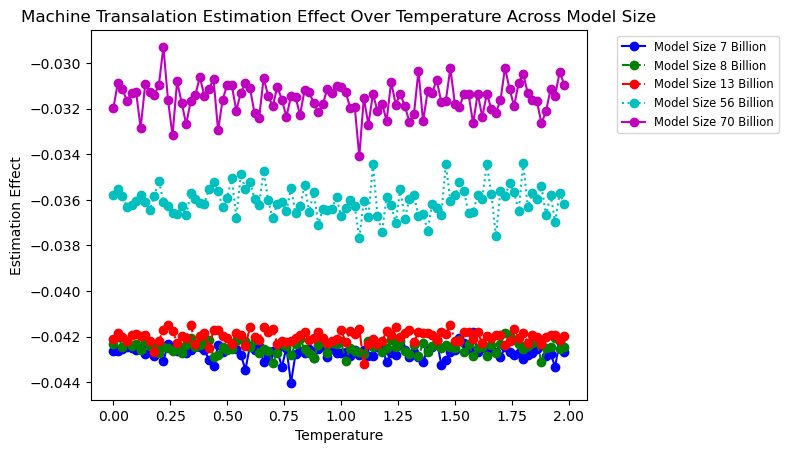

In [82]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

grouped = results_df.groupby("weight_size")

colors = ["b", "g", "r", "c", "m", "y", "k"]
linestyles = ["-", "--", "-.", ":"]

for i, (name, group) in enumerate(grouped):
    color = colors[i % len(colors)]
    linestyle = linestyles[i % len(linestyles)]
    ax.plot(
        group["control_value"],
        group["estimation_effect"],
        marker="o",
        linestyle=linestyle,
        label=f"Model Size {name} Billion",
        color=color,
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.title("Machine Transalation Estimation Effect Over Temperature Across Model Size")
plt.xlabel("Temperature")
plt.ylabel("Estimation Effect")
plt.show()

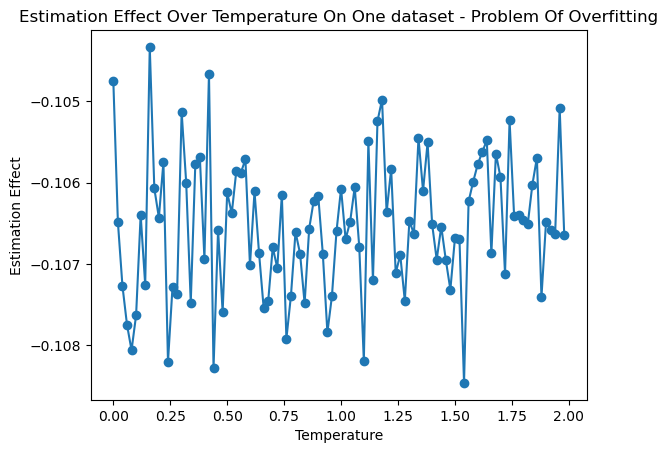

In [ ]:
import matplotlib.pyplot as plt

plt.plot(
    results_df["control_value"],
    results_df["estimation_effect"],
    marker="o",
    linestyle="-",
)

plt.title("Estimation Effect Over Temperature On One dataset - Problem Of Overfitting")
plt.xlabel("Temperature")
plt.ylabel("Estimation Effect")
plt.show()

Effect estimation + Refutation

In [ ]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

start = 0
end = 2
num_points = 20
step = (end - start) / num_points
points = np.arange(start, end, step)

results_df = pd.DataFrame(
    columns=[
        "control_value",
        "treatement_value",
        "estimation_interpretation",
        "estimation_params",
        "estimation_effect",
        "res_random_refutation_results",
        "res_random_refutation_new_effect",
        "res_random_refutation_estimated_effect",
        "placbo_refutation_results",
        "placbo_refutation_new_effect",
        "placbo_refutation_estimated_effect",
    ]
)

for point in points:
    dml_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.econml.dml.DML",
        control_value=point,
        treatment_value=point + step,
        confidence_intervals=False,
        # evaluate_effect_strength=True,
        method_params={
            "init_params": {
                "model_y": GradientBoostingRegressor(),
                "model_t": GradientBoostingRegressor(),
                "model_final": LassoCV(fit_intercept=False),
                "featurizer": PolynomialFeatures(degree=1, include_bias=False),
            },
            "fit_params": {},
        },
    )

    res_random = model.refute_estimate(
        identified_estimand,
        dml_estimate,
        method_name="random_common_cause",
    )

    res_placebo = model.refute_estimate(
        identified_estimand,
        dml_estimate,
        method_name="placebo_treatment_refuter",
        show_progress_bar=True,
    )

    # results_df = results_df.append(
    #     {
    #         "estimation_interpretation": dml_estimate.interpret(),
    #         "estimation_params": dml_estimate.params,
    #         "estimation_effect": dml_estimate.value,
    #         "res_random_refutation_results": res_random.refutation_result,
    #         "res_random_refutation_new_effect": res_random.new_effect,
    #         "res_random_refutation_estimated_effect": res_random.estimated_effect,
    #         "placbo_refutation_results": res_placebo.refutation_result,
    #         "placbo_refutation_new_effect": res_placebo.new_effect,
    #         "placbo_refutation_estimated_effect": res_placebo.estimated_effect,
    #     },
    #     ignore_index=True,
    # )

    new_data = {
        "control_value": point,
        "treatement_value": point + step,
        "estimation_interpretation": dml_estimate.interpret().__str__(),
        "estimation_params": [dml_estimate.params],
        "estimation_effect": [dml_estimate.value],
        "res_random_refutation_results": [res_random.refutation_result],
        "res_random_refutation_new_effect": [res_random.new_effect],
        "res_random_refutation_estimated_effect": [res_random.estimated_effect],
        "placbo_refutation_results": [res_placebo.refutation_result],
        "placbo_refutation_new_effect": [res_placebo.new_effect],
        "placbo_refutation_estimated_effect": [res_placebo.estimated_effect],
    }

    new_data_df = pd.DataFrame(new_data)
    results_df = pd.concat([results_df, new_data_df], ignore_index=True)
    print(len(results_df))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.0 to [0.1] causes an increase of -0.531124016904316 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.1 to [0.2] causes an increase of -0.5403694259516022 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
2


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.2 to [0.30000000000000004] causes an increase of -0.5376812641035948 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
3


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.30000000000000004 to [0.4] causes an increase of -0.5421741563878909 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
4


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.4 to [0.5] causes an increase of -0.5347837151127585 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
5


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.5 to [0.6] causes an increase of -0.5464363216046043 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
6


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.6000000000000001 to [0.7000000000000001] causes an increase of -0.5311757171908504 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
7


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.7000000000000001 to [0.8] causes an increase of -0.5392701066813751 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
8


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.8 to [0.9] causes an increase of -0.5428373502778704 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
9


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.9 to [1.0] causes an increase of -0.5300997057495361 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.0 to [1.1] causes an increase of -0.5313493312587284 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
11


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.1 to [1.2000000000000002] causes an increase of -0.5381474154607395 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
12


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.2000000000000002 to [1.3000000000000003] causes an increase of -0.5432550894872603 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
13


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.3 to [1.4000000000000001] causes an increase of -0.5372225986203432 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
14


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.4000000000000001 to [1.5000000000000002] causes an increase of -0.5344362156043794 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
15


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.5 to [1.6] causes an increase of -0.5391915060937139 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
16


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.6 to [1.7000000000000002] causes an increase of -0.5379042442485084 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
17


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.7000000000000002 to [1.8000000000000003] causes an increase of -0.534326166471493 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
18


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.8 to [1.9000000000000001] causes an increase of -0.5374489688025789 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
19


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.9000000000000001 to [2.0] causes an increase of -0.5426206175091743 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
20


In [ ]:
results_df.to_csv(
    "/Users/lujun.li/projects/causallm-github/causalllm/script/ML/causal_analysis.csv"
)

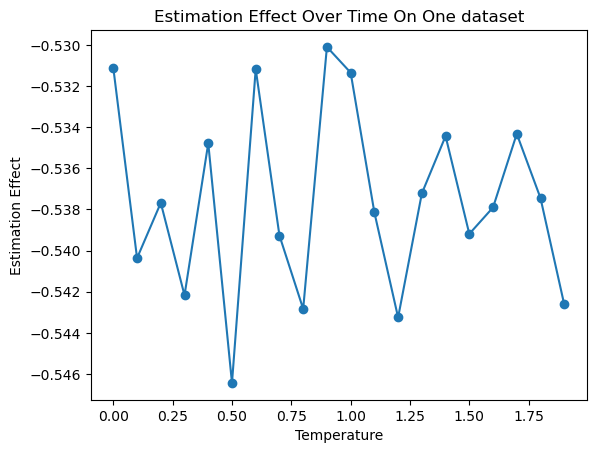

In [ ]:
import matplotlib.pyplot as plt

# 多个dataset再进行estimation
plt.plot(
    results_df["control_value"],
    results_df["estimation_effect"],
    marker="o",
    linestyle="-",
)

plt.title("Estimation Effect Over Temperature On One dataset - Problem Of Overfitting")
plt.xlabel("Temperature")
plt.ylabel("Estimation Effect")
plt.show()

In [ ]:
res_random = model.refute_estimate(
    identified_estimand,
    dml_estimate,
    method_name="random_common_cause",
    show_progress_bar=True,
)
print(res_random)


res_placebo = model.refute_estimate(
    identified_estimand,
    dml_estimate,
    method_name="placebo_treatment_refuter",
    show_progress_bar=True,
    placebo_type="permute",
)


print(res_random)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting Estimates:   1%|          | 1/100 [00:00<00:25,  3.82it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting Estimates:   2%|▏         | 2/100 [00:00<00:22,  4.37it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting 

Refute: Add a random common cause
Estimated effect:-0.5380224444357403
New effect:-0.5318980649928892
p value:0.6599999999999999



Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting Estimates:   1%|          | 1/100 [00:00<00:11,  8.53it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting Estimates:   2%|▏         | 2/100 [00:00<00:11,  8.83it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting 

Refute: Add a random common cause
Estimated effect:-0.5380224444357403
New effect:-0.5318980649928892
p value:0.6599999999999999



In [ ]:
res_placebo.new_effect

res_placebo.estimated_effect

In [ ]:
res_random.refutation_result

{'p_value': 0.6599999999999999, 'is_statistically_significant': False}

In [ ]:
res_placebo.estimated_effect

In [ ]:
res_placebo.refutation_result

{'p_value': 0.8799999999999999, 'is_statistically_significant': False}

In [ ]:
res_placebo.add_significance_test_results

<bound method CausalRefutation.add_significance_test_results of <dowhy.causal_refuter.CausalRefutation object at 0x3ef14f5e0>>

In [ ]:
print(dml_estimate.interpret())

Increasing the treatment variable(s) [Temperature] from 0 to [0.1] causes an increase of -0.5380224444357403 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
None


In [ ]:
dml_estimate.test_stat_significance()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'p_value': 0.109}

In [ ]:
dml_estimate.value

In [ ]:
dml_estimate

# Post-hoc Refutation test 